ДЗ № 5: LSTM - Долгая краткосрочная память - предсказание движений человека
---

Приложен [ноутбук](https://colab.research.google.com/drive/1WuyxuftSjZpGICdN2nq612y2WOD5L85Z?usp=sharing), в котором реализованы функции для генерации из большого датасета в меньшую его копию. Вам нужно сделать следующее: 
1. Сгенерировать меньший датасет из 8-10 классов движения
2. Обучить уже существующую модель (предварительно проанализировав, какие параметры модели нужно изменить)
3. Изменить модель: посмотреть зависимость от количества LSTM модулей в модели  
4. *Сгенерировать другой датасет с меньшим количеством “кадров” в серии и сравнить улучшилось или ухудшилось качество предсказания. Провести несколько таких итераций, дать свою оценку уменьшению и увеличению кадров, назвать оптимальное, на ваш взгляд, их количество.

В датасете есть некторые файлики с пропущенными скелетами (без соединений). Это тоже нужно подгрузить.

Классы лучше выбирать похожие, которые легко перепутать, например положить что-то в сумку и вытащить что-то из сумки.

# Подготовка данных

Изначальный датасет довольно избыточный, поэтому для проведения задания мы пользуемся этим ноутбуком, чтобы взять только нужную часть

Скачать весь датасет (~5 Гб) можно по этой ссылке: https://drive.google.com/file/d/1CUZnBtYwifVXS21yVg62T-vrPVayso5H/view

Файл с отсутствующими скелетами можно скачать из репозитория либо с google диска wget: https://github.com/shahroudy/NTURGB-D/blob/master/Matlab/NTU_RGBD_samples_with_missing_skeletons.txt

In [1]:
!gdown 'https://drive.google.com/uc?export=dowloa&id=1CUZnBtYwifVXS21yVg62T-vrPVayso5H'

Downloading...
From: https://drive.google.com/uc?export=dowloa&id=1CUZnBtYwifVXS21yVg62T-vrPVayso5H
To: /content/nturgbd_skeletons_s001_to_s017.zip
6.18GB [01:56, 53.1MB/s]


In [2]:
!unzip /content/nturgbd_skeletons_s001_to_s017.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: nturgb+d_skeletons/S004C002P003R002A043.skeleton  
  inflating: nturgb+d_skeletons/S011C001P025R002A017.skeleton  
  inflating: nturgb+d_skeletons/S006C001P008R002A022.skeleton  
  inflating: nturgb+d_skeletons/S007C001P019R001A001.skeleton  
  inflating: nturgb+d_skeletons/S015C001P016R002A037.skeleton  
  inflating: nturgb+d_skeletons/S007C001P019R002A005.skeleton  
  inflating: nturgb+d_skeletons/S008C002P007R002A058.skeleton  
  inflating: nturgb+d_skeletons/S002C001P010R002A012.skeleton  
  inflating: nturgb+d_skeletons/S006C003P008R002A019.skeleton  
  inflating: nturgb+d_skeletons/S014C003P039R002A013.skeleton  
  inflating: nturgb+d_skeletons/S016C001P008R002A030.skeleton  
  inflating: nturgb+d_skeletons/S004C001P003R002A035.skeleton  
  inflating: nturgb+d_skeletons/S009C003P008R001A049.skeleton  
  inflating: nturgb+d_skeletons/S014C001P015R002A008.skeleton  
  inflating: nturgb+d_skeletons/S006

In [3]:
!wget 'https://drive.google.com/uc?export=download&id=1BTN5ytqfKi71ZX6xG-ve5ETG89h0Bm1g' -O NTU_RGBD_samples_with_missing_skeletons.txt

--2021-09-22 18:50:42--  https://drive.google.com/uc?export=download&id=1BTN5ytqfKi71ZX6xG-ve5ETG89h0Bm1g
Resolving drive.google.com (drive.google.com)... 142.250.152.139, 142.250.152.113, 142.250.152.138, ...
Connecting to drive.google.com (drive.google.com)|142.250.152.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tg0gpipg63gbi7rcrjksgmqgat7sii54/1632336600000/14904333240138417226/*/1BTN5ytqfKi71ZX6xG-ve5ETG89h0Bm1g?e=download [following]
--2021-09-22 18:50:43--  https://doc-04-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tg0gpipg63gbi7rcrjksgmqgat7sii54/1632336600000/14904333240138417226/*/1BTN5ytqfKi71ZX6xG-ve5ETG89h0Bm1g?e=download
Resolving doc-04-c0-docs.googleusercontent.com (doc-04-c0-docs.googleusercontent.com)... 142.250.148.132, 2607:f8b0:4001:c54::84
Connecting to doc-04-c0-docs.googleusercontent.com (d

In [4]:
data_path = "/content/nturgb+d_skeletons/"
# список отсутсвующих элементов
broken_files_path = "/content/NTU_RGBD_samples_with_missing_skeletons.txt"

In [5]:
training_classes = [20, 21, 29, 30, 69, 70, 87, 88, 91, 100, 100, 100] # классы которые будем использовать
#training_classes = [8, 10, 22, 23, 27]
# A20. put on a hat/cap.
# A21. take off a hat/cap.
# A29. playing with phone/tablet.
# A30. typing on a keyboard.
# A69. thumb up.
# A70. thumb down.
# A87. put on bag.
# A88. take off bag.
# A91. open a box.


# для обучения, полный список представлен тут https://github.com/shahroudy/NTURGB-D

training_cameras = [1, 2, 3] # используем 3 основные камеры, есть ещё инфракрасные

amount_of_samples = 120 # можно поварьировать количество объектов
num_joint = 25 # кол-во соединений не меняется
max_frame = 45  # Длина отрезка которую мы достаем из датасета (можно поменять)

Есть функция, которая позволяет нам считать данные для каждого класса. Данные лежат в формате skeleton.

Файл данных имеет имя в виде `['S008C001P035R001A027.skeleton', 0]` где:
- С001 - первая камера
- P035 - человек
- R001
- A027 - действие

Нас интересует камера и действие. Поэтому именно это мы и будем доставать из имени файла.

In [6]:
def read_data(data_path, broken_files_path):
    labels = []
    files = []
    action_classes = {}
    counter = 0
    files_counter = {}
              
    with open(broken_files_path, 'r') as f:
        broken_files = f.read().split("\n")

    raw_files = os.listdir(data_path)
    num_frames = 0

    for filename in raw_files:
        # если файлы сломанные, то мы с ними не работаем
        if filename not in broken_files:
            action_class = int(filename[filename.find('A') + 1:filename.find('A') + 4])
            camera_id = int(filename[filename.find('C') + 1:filename.find('C') + 4])
            
            # если камера из первых 3-х и кол-во действий меньше желаемого, добавляем действие в обучающий датасет
            if action_class in training_classes and camera_id in training_cameras:
                if action_class in action_classes:
                    if files_counter[action_class] < amount_of_samples:
                        files.append([filename, action_classes[action_class]])
                        files_counter[action_class] = files_counter[action_class] + 1
                else:
                    action_classes.update({action_class : counter})
                    files_counter.update({action_class : 1})
                    counter += 1
                    files.append([filename, action_classes[action_class]])

    print("action classes: ", action_classes)
    print("action files: ", files_counter)
    
    return files, action_classes

In [7]:
# Функция фильтр для того, что бы найти только координаты x, y, z (т.к. в датасете
# хранится на порядок больше информации, нежели только координаты x,y,z)
# (Остальные данные нам и не нужны, т.к. у нас нет ик-камер)
def read_skeleton_filter(file):
    with open(file, 'r') as f:
        skeleton_sequence = {}
        skeleton_sequence['numFrame'] = int(f.readline())
        skeleton_sequence['frameInfo'] = []

        for t in range(skeleton_sequence['numFrame']):
            frame_info = {}
            frame_info['numBody'] = int(f.readline())
            frame_info['bodyInfo'] = []

            for m in range(frame_info['numBody']):
                body_info = {}
                body_info_key = [
                    'bodyID', 'clipedEdges', 'handLeftConfidence',
                    'handLeftState', 'handRightConfidence', 'handRightState',
                    'isResticted', 'leanX', 'leanY', 'trackingState'
                ]
                body_info = {
                    k: float(v)
                    for k, v in zip(body_info_key, f.readline().split())
                }
                body_info['numJoint'] = int(f.readline())
                body_info['jointInfo'] = []
                for v in range(body_info['numJoint']):
                    joint_info_key = [
                        'x', 'y', 'z', 'depthX', 'depthY', 'colorX', 'colorY',
                        'orientationW', 'orientationX', 'orientationY',
                        'orientationZ', 'trackingState'
                    ]
                    joint_info = {
                        k: float(v)
                        for k, v in zip(joint_info_key, f.readline().split())
                    }
                    body_info['jointInfo'].append(joint_info)
                frame_info['bodyInfo'].append(body_info)
            skeleton_sequence['frameInfo'].append(frame_info)

    return skeleton_sequence

def read_xyz(file, max_body=1, num_joint=25):
    seq_info = read_skeleton_filter(file)
    data = np.zeros((max_body, seq_info['numFrame'], num_joint, 3))
    for n, f in enumerate(seq_info['frameInfo']):
        for m, b in enumerate(f['bodyInfo']):
            for j, v in enumerate(b['jointInfo']):
                if m < max_body and j < num_joint:
                    data[m, n, j, :] = [v['x'], v['y'], v['z']]

    return data

**В этой функции меняем количество фреймов подаваемых на вход модели**

В задании нужно пронаблюдать зависимость качества обучения модели от количества кадров, которые мы подаем в модель. Т.е. то, cколько кадров у нас отведено на один блок. По умолчанию 45 кадров, можно взять поменьше или побольше.

По хорошему функцию ниже нужно прописать внутри определения датасета.

In [8]:
def create_coords_blocks(data, chunk_len=45):
    # нарезание видео на кадры
    frame_counter = 0
    new_labels = []
    new_frames = []
    blocks = []
    
    test_frames = read_xyz(data_path + data[0])[0]
    label = data[1]
    slice_len = chunk_len * int(len(test_frames)/chunk_len)


    for index in range(len(test_frames[:slice_len])):
        frame_counter += 1
        new_frames.append(test_frames[index].flatten())
        if frame_counter == chunk_len:
            frame_counter = 0
            blocks.append(np.array(new_frames))
            new_labels = new_labels + [label]
            new_frames = []
       
            
    return blocks, new_labels

In [9]:
# список файлов с лейблами на каждый файл 
import os
import numpy as np
import pandas as pd


working_files_with_labels, action_classes = read_data(data_path, broken_files_path)

action classes:  {21: 0, 20: 1, 29: 2, 30: 3}
action files:  {21: 120, 20: 120, 29: 120, 30: 120}


In [10]:
LABELS = {v: k for k, v in action_classes.items()}

Здесь выносится сгенерированный список лейблов с номером класса.

In [11]:
LABELS

{0: 21, 1: 20, 2: 29, 3: 30}

In [12]:
working_files_with_labels[:10]

[['S014C002P007R001A021.skeleton', 0],
 ['S007C003P028R002A020.skeleton', 1],
 ['S014C002P017R002A020.skeleton', 1],
 ['S013C001P018R001A029.skeleton', 2],
 ['S013C001P025R001A029.skeleton', 2],
 ['S006C003P017R001A030.skeleton', 3],
 ['S006C003P015R002A029.skeleton', 2],
 ['S008C001P036R001A029.skeleton', 2],
 ['S012C003P027R001A030.skeleton', 3],
 ['S014C001P037R001A030.skeleton', 3]]

In [13]:
# кол-во объектов
len(working_files_with_labels)

480

In [14]:
# оформляем набор точек и набор классов
data = []
labels = []
numbers = {0: 0, 1 : 0, 2 : 0, 3 : 0, 4 :0}
for file_label in working_files_with_labels:
    frames_blocks, label = create_coords_blocks(file_label, chunk_len=max_frame)
    
    # если нужного класса нет
    if label != [] and numbers[label[0]] < amount_of_samples:
        numbers[label[0]] = numbers[label[0]] + len(label)
        data = data + frames_blocks
        labels = labels + label


data_np = np.asarray(data)
labels_np = np.asarray(labels)

data_sq = data_np.reshape(len(data_np), -1)
test_data = pd.DataFrame(data_sq)
test_labels = pd.DataFrame(labels_np)
test_data['labels'] = test_labels

Видим, что у нулевого класса на 3 объекта меньше, он не обнаружился на кадре.

In [15]:
numbers

{0: 120, 1: 120, 2: 122, 3: 120, 4: 0}

In [16]:
test_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3336,3337,3338,3339,3340,3341,3342,3343,3344,3345,3346,3347,3348,3349,3350,3351,3352,3353,3354,3355,3356,3357,3358,3359,3360,3361,3362,3363,3364,3365,3366,3367,3368,3369,3370,3371,3372,3373,3374,labels
0,-0.335672,0.352535,3.900033,-0.328221,0.638419,3.795749,-0.317868,0.915675,3.680047,-0.332594,1.060432,3.659376,-0.525162,0.884557,3.786735,-0.359820,0.690784,3.669680,-0.204782,0.474046,3.710865,-0.220538,0.427131,3.731870,-0.259718,0.725274,3.629894,-0.269910,0.499322,3.627692,-0.314797,0.268558,3.718285,-0.320855,0.209615,3.770458,-0.386418,0.362246,3.884342,-0.316670,...,-0.373387,0.391342,3.886050,-0.329036,0.059057,3.887070,-0.249139,-0.398863,4.095697,-0.299629,-0.474363,3.994544,-0.241359,0.370162,3.806071,-0.291368,-0.018934,3.936476,-0.243067,-0.433187,4.113675,-0.293621,-0.508408,4.012547,-0.330682,0.854102,3.681769,-0.426133,1.071403,3.490284,-0.382109,1.059320,3.501667,-0.506950,0.981277,3.433950,-0.488482,0.878053,3.432900,0
1,-0.355015,-0.314615,2.988860,-0.353206,-0.084782,3.034140,-0.350125,0.141945,3.068633,-0.323894,0.235279,3.135724,-0.480021,0.111822,3.161422,-0.411834,-0.073055,2.985714,-0.408856,-0.266774,2.812746,-0.413220,-0.313694,2.774267,-0.355762,0.047970,2.933103,-0.288976,-0.198452,2.931707,-0.201657,-0.435743,2.899637,-0.208305,-0.443928,2.919622,-0.368873,-0.295337,2.905079,-0.685214,...,-0.343550,-0.288738,2.933676,-0.690329,-0.057340,2.900775,-0.595522,-0.433752,2.742868,-0.619827,-0.511884,2.677823,-0.323025,-0.305376,3.024728,-0.085134,-0.480049,2.944808,-0.099696,-0.703237,2.888362,-0.004135,-0.738775,2.817006,-0.363479,0.099154,3.069756,-0.438847,-0.465162,2.729374,-0.437523,-0.435548,2.720600,-0.317805,0.365367,3.078396,-0.278695,0.373945,3.117714,1
2,-0.336160,-0.299518,3.007680,-0.353699,-0.071929,3.047508,-0.365892,0.153593,3.077714,-0.369980,0.277559,3.135093,-0.393752,0.024883,2.944592,-0.380370,-0.204656,2.859655,-0.422829,-0.354143,2.746373,-0.431162,-0.407372,2.758032,-0.259429,0.132681,3.319342,-0.187015,0.276480,3.401477,-0.250193,0.376017,3.247175,-0.294645,0.367335,3.124931,-0.342764,-0.288684,2.934429,-0.694219,...,-0.343377,-0.314418,2.916110,-0.691067,-0.084551,2.868021,-0.600182,-0.431028,2.738951,-0.498354,-0.469913,2.671633,-0.328743,-0.338985,3.021515,-0.048334,-0.470122,2.961567,-0.086741,-0.808626,2.865997,0.009804,-0.844051,2.798780,-0.360346,0.096097,3.061600,-0.433658,-0.432480,2.728797,-0.442648,-0.397331,2.742500,-0.051316,-0.249238,3.086342,-0.117296,-0.216233,3.128028,1
3,-0.209969,0.178274,3.760975,-0.201940,0.384027,3.687253,-0.193030,0.585828,3.603677,-0.199763,0.707204,3.562312,-0.334247,0.498257,3.631485,-0.391485,0.288177,3.675034,-0.403714,0.076616,3.727548,-0.392398,0.040690,3.753313,-0.056910,0.486433,3.613024,-0.012332,0.281815,3.667190,-0.021683,0.081008,3.701180,-0.037398,0.020854,3.708529,-0.272280,0.179429,3.730302,-0.083605,...,-0.242433,0.271567,3.717447,-0.242177,0.574347,3.589312,-0.277411,0.094878,3.736023,-0.313973,0.024581,3.640035,-0.126475,0.274194,3.700084,0.099230,0.487185,3.594068,-0.095900,0.091594,3.717559,-0.081111,0.033125,3.748972,-0.171099,0.588739,3.612147,-0.230875,0.878643,3.560312,-0.227563,0.805230,3.466357,-0.157611,0.543054,3.220815,-0.159648,0.517261,3.227253,1
4,-0.187085,0.275722,3.741896,-0.178275,0.454738,3.673538,-0.166118,0.629822,3.589019,-0.181586,0.767669,3.556593,-0.302443,0.575537,3.659763,-0.421029,0.668839,3.523381,-0.307795,0.806770,3.557412,-0.268828,0.823646,3.552078,-0.075380,0.621630,3.544724,0.011414,0.450790,3.471137,-0.110414,0.478864,3.261760,-0.127594,0.544359,3.241180,-0.244038,0.272203,3.718400,-0.240814,...,-0.263575,0.232224,3.787304,-0.306175,0.510099,3.607784,-0.283490,0.085780,3.726658,-0.305330,0.012047,3.627672,-0.150592,0.216067,3.764573,0.027415,0.393238,3.505046,-0.119454,0.089800,3.711030,-0.086615,0.009881,3.695170,-0.195820,0.575110,3.644228,-0.266353,0.776950,3.514660,-

**Ваш итоговый файл**

In [17]:
test_data.to_csv("new_skels.csv", index=False)

# Обучение LSTM модели

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

import time
import math

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [19]:
class LSTM(nn.Module):
    def __init__(self, input_dim,hidden_dim, output_layer, layer_num):
        super().__init__()
        self.hidden_layer = hidden_layer
        self.output_layer = output_layer
        self.lstm = torch.nn.LSTM(input_dim, hidden_layer, layer_num, batch_first=True)
        self.dr = torch.nn.Dropout2d(0.1)
        self.fc = torch.nn.Linear(hidden_layer, output_layer)
        
    def forward(self, inputs):
        lstm_out, (hn, cn) = self.lstm(inputs)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [20]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        self.labels = self.data.iloc[:,-1]

    def __len__(self):
        return len(self.data)     

    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(45,25*3)
        label = self.labels[idx]
        if self.transform != None:
            item = transform(item)

        return (item, label)

In [21]:
dataset = Skeleton_Dataset(file_path = "new_skels.csv", transform=None)

In [22]:
skeleton, label = dataset[41]
label, skeleton

(0, array([[-0.1342723 , -0.2269721 ,  2.354551  , ...,  0.061586  ,
         -0.2890356 ,  2.569863  ],
        [-0.0037567 , -0.2289932 ,  2.508783  , ...,  0.1229077 ,
         -0.2483622 ,  2.498166  ],
        [-0.05115713, -0.2225799 ,  2.415844  , ..., -0.1029667 ,
         -0.2004191 ,  2.159588  ],
        ...,
        [-0.03574228, -0.1871398 ,  2.415511  , ...,  0.1253904 ,
          0.5679132 ,  2.317947  ],
        [-0.03042554, -0.1992111 ,  2.419875  , ...,  0.3146518 ,
          0.5303225 ,  2.1641    ],
        [-0.02725371, -0.2273629 ,  2.41763   , ...,  0.2696823 ,
          0.5565817 ,  2.250625  ]]))

In [23]:
LABELS[label], skeleton.shape

(21, (45, 75))

In [24]:
train_shape = 0.7
train_len = int(train_shape * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_len, len(dataset) - train_len])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

In [25]:
input_layer = 25 * 3
hidden_layer = 128
output_layer = len(LABELS)
layer_num = 2
model = LSTM(input_layer, hidden_layer, output_layer, layer_num)
model.to(device)

LSTM(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)

In [26]:
def get_target_from_output(output):
    top_n, top_i = output.topk(1)

    category_i = top_i[0].item()

    return LABELS[category_i], category_i

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [27]:
learning_rate = 0.001
momentum = 0.95

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(
    model.parameters(), 
    lr=learning_rate, 
    momentum=momentum
)

losses = []
start = time.time()
counter = 0

for epoch in range(600):  
    loss = 0

    for i, data in enumerate(train_loader, 0):
        inputs = data[0].to(device)
        labels = data[1].to(device)

        optimizer.zero_grad()
  
        output = model(inputs.float())

        loss = criterion(output, labels)
        loss.backward()
        
        optimizer.step() 

        loss += loss.item()

        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = get_target_from_output(output)
            
            correct = '✓' if guess == category else '✗ (%s)' % category

            print('Epoch %d iteration: %d (%s) %.4f  / %s %s' % (epoch, i, time_since(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        losses.append(loss / 25)
        loss = 0

Epoch 0 iteration: 0 (0m 0s) 2.8334  / 30 ✗ (21)
Epoch 22 iteration: 16 (0m 24s) 2.5929  / 30 ✓
Epoch 45 iteration: 10 (0m 48s) 2.8060  / 29 ✗ (21)
Epoch 68 iteration: 4 (1m 11s) 2.5303  / 30 ✗ (29)
Epoch 90 iteration: 20 (1m 35s) 2.5908  / 30 ✗ (29)
Epoch 113 iteration: 14 (1m 59s) 2.0251  / 29 ✓
Epoch 136 iteration: 8 (2m 22s) 2.4920  / 20 ✗ (29)
Epoch 159 iteration: 2 (2m 46s) 2.7410  / 20 ✗ (29)
Epoch 181 iteration: 18 (3m 10s) 2.2222  / 20 ✓
Epoch 204 iteration: 12 (3m 34s) 2.3282  / 20 ✓
Epoch 227 iteration: 6 (3m 57s) 2.9364  / 20 ✓
Epoch 250 iteration: 0 (4m 21s) 2.3688  / 30 ✗ (29)
Epoch 272 iteration: 16 (4m 45s) 2.7183  / 20 ✓
Epoch 295 iteration: 10 (5m 9s) 2.1610  / 20 ✗ (21)
Epoch 318 iteration: 4 (5m 33s) 2.5334  / 30 ✗ (21)
Epoch 340 iteration: 20 (5m 57s) 2.3736  / 29 ✗ (30)
Epoch 363 iteration: 14 (6m 21s) 2.0914  / 29 ✓
Epoch 386 iteration: 8 (6m 44s) 2.9040  / 21 ✗ (20)
Epoch 409 iteration: 2 (7m 8s) 2.9174  / 30 ✗ (29)
Epoch 431 iteration: 18 (7m 32s) 2.9636  / 20 

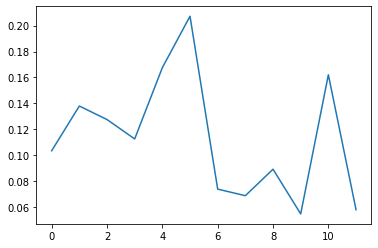

In [28]:
losses_number = len(losses)

plt.plot(
    list(range(0, losses_number)),
    losses
)

plt.show()

## LSTM с большим количеством модулей

In [32]:
del model

In [33]:
input_layer = 25 * 3
hidden_layer = 128
output_layer = len(LABELS)
layer_num = 3
model = LSTM(input_layer, hidden_layer, output_layer, layer_num)
model.to(device)

LSTM(
  (lstm): LSTM(75, 128, num_layers=3, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)

In [34]:
learning_rate = 0.001
momentum = 0.95

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(
    model.parameters(), 
    lr=learning_rate, 
    momentum=momentum
)

losses = []
start = time.time()
counter = 0

for epoch in range(600):  
    loss = 0

    for i, data in enumerate(train_loader, 0):
        inputs = data[0].to(device)
        labels = data[1].to(device)

        optimizer.zero_grad()
  
        output = model(inputs.float())

        loss = criterion(output, labels)
        loss.backward()
        
        optimizer.step() 

        loss += loss.item()

        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = get_target_from_output(output)
            
            correct = '✓' if guess == category else '✗ (%s)' % category

            print('Epoch %d iteration: %d (%s) %.4f  / %s %s' % (epoch, i, time_since(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        losses.append(loss / 25)
        loss = 0

Epoch 0 iteration: 0 (0m 0s) 2.7493  / 30 ✗ (21)
Epoch 22 iteration: 16 (0m 25s) 2.7758  / 29 ✗ (30)
Epoch 45 iteration: 10 (0m 51s) 2.7462  / 29 ✗ (21)
Epoch 68 iteration: 4 (1m 16s) 2.6965  / 30 ✗ (20)
Epoch 90 iteration: 20 (1m 42s) 2.7062  / 29 ✗ (30)
Epoch 113 iteration: 14 (2m 7s) 2.6959  / 29 ✗ (20)
Epoch 136 iteration: 8 (2m 33s) 3.0607  / 30 ✗ (20)
Epoch 159 iteration: 2 (2m 59s) 2.6589  / 20 ✗ (29)
Epoch 181 iteration: 18 (3m 25s) 2.4749  / 20 ✓
Epoch 204 iteration: 12 (3m 51s) 1.7855  / 30 ✓
Epoch 227 iteration: 6 (4m 17s) 2.5286  / 20 ✗ (21)
Epoch 250 iteration: 0 (4m 42s) 2.0155  / 29 ✓
Epoch 272 iteration: 16 (5m 8s) 2.3756  / 30 ✗ (21)
Epoch 295 iteration: 10 (5m 34s) 2.2117  / 20 ✓
Epoch 318 iteration: 4 (6m 0s) 2.6606  / 21 ✗ (20)
Epoch 340 iteration: 20 (6m 25s) 1.9819  / 20 ✓
Epoch 363 iteration: 14 (6m 51s) 2.2710  / 30 ✗ (20)
Epoch 386 iteration: 8 (7m 16s) 2.6383  / 30 ✓
Epoch 409 iteration: 2 (7m 42s) 2.4478  / 29 ✗ (21)
Epoch 431 iteration: 18 (8m 8s) 2.6175  / 

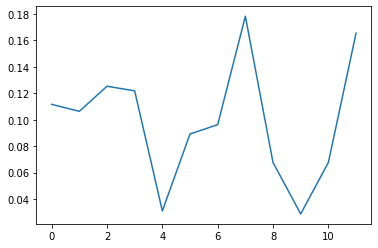

In [35]:
losses_number = len(losses)

plt.plot(
    list(range(0, losses_number)),
    losses
)

plt.show()

Кардинального изменения не заметно.